# Floresta Aleatória
**Variáveis Agregadas (2018-2024)** \\
 \\
Bootcamp Machine Learning ENAP 2024 \\
Maurício Marques Soares Filho \\
25/10/2024 \\

## Imports...

In [1]:
!pip install dtreeviz
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.1 MB/s eta 0:00:00


In [2]:
###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dtreeviz

###
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.inspection import permutation_importance

###
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

###
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV

###
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier


###
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV

###
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Pré-processamento dos dados

In [3]:
#Estilizar conteúdo
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

def estilo_tabelas(df, max_altura='300px', casas_decimais=3):
    return (
        df.style.set_table_styles(
            [
                {'selector': 'thead th', 'props': [('font-size', '12px'), ('text-align', 'center'), ('border-bottom', '2px solid #007BFF')]},
                {'selector': 'td', 'props': [('font-size', '10px'), ('text-align', 'center'), ('max-height', '40px'), ('white-space', 'nowrap'), ('text-overflow', 'ellipsis'), ('overflow', 'hidden'), ('max-width', '100px')]},
                {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]},
                {'selector': 'table', 'props': [('width', '90%'), ('margin-left', 'auto'), ('margin-right', 'auto'), ('border-collapse', 'collapse')]},
                {'selector': 'td, th', 'props': [('border', '1px solid #666')]},  # Bordas cinza escuro
            ]
        ).set_properties(
            **{'border-color': 'darkgray', 'border-style': 'solid', 'border-width': '1px'}
        ).set_table_attributes(
            f'style="height:auto; overflow:auto; max-height:{max_altura}; display:block;"'
        ).format(
            precision=casas_decimais
        )
    )

In [4]:
# Importar a base de dados
df_eventos_2018_2024_modelo1 = pd.read_csv(
    "https://raw.githubusercontent.com/brunagmoura/PrevisorReconhecimento/refs/heads/main/df_eventos_2018_2024_modelo1.csv",
    sep=';',
    decimal=',',
)

estilo_tabelas(df_eventos_2018_2024_modelo1.head(5))

,Status,DH_total_danos_humanos,DM_total_danos_materiais,PEPL_total_publico,PEPR_total_privado,regiao_Centro-oeste,regiao_Nordeste,regiao_Norte,regiao_Sudeste,regiao_Sul,COBRADE_11110,COBRADE_11120,COBRADE_11311,COBRADE_11312,COBRADE_11313,COBRADE_11321,COBRADE_11331,COBRADE_11332,COBRADE_11340,COBRADE_11410,COBRADE_11420,COBRADE_11431,COBRADE_11432,COBRADE_11433,COBRADE_12100,COBRADE_12200,COBRADE_12300,COBRADE_13111,COBRADE_13112,COBRADE_13120,COBRADE_13211,COBRADE_13212,COBRADE_13213,COBRADE_13214,COBRADE_13215,COBRADE_13310,COBRADE_13321,COBRADE_13322,COBRADE_14110,COBRADE_14120,COBRADE_14131,COBRADE_14132,COBRADE_14140,COBRADE_15110,COBRADE_15120,COBRADE_15130,COBRADE_15210,COBRADE_15230,COBRADE_22210,COBRADE_22220,COBRADE_23120,COBRADE_24100,COBRADE_24200,COBRADE_25100,COBRADE_25500,DOMICILIO_AREARURAL,PDEFAGUA,PDEFESGOTO,PDEFLIXO,PDEFSAN,QTDE_FAMILIAS_ATUALIZADAS
0,1,11650,0.000,132466.926,861035.020,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.305,0.191,0.559,0.167,0.091,383.000
1,1,2548,0.000,103709.315,6509159.048,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.632,0.246,0.456,0.175,0.070,57.000
2,0,336,2296093.386,1928129.702,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.708,0.691,0.851,0.691,0.576,356.000
3,1,420,9811880.000,8974880.000,29950000.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.187,0.098,0.992,0.139,0.077,632.000
4,1,13245,0.000,286229.997,1353851.954,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.242,0.157,0.187,0.063,0.028,2231.000


In [5]:
# Remover linhas com dados ausentes
df_eventos_2018_2024_modelo1 = df_eventos_2018_2024_modelo1.dropna()
estilo_tabelas(df_eventos_2018_2024_modelo1.head(5))

# Remover registros em que todos os dados informados são 0
df_eventos_2018_2024_modelo1 = df_eventos_2018_2024_modelo1[
    ~((df_eventos_2018_2024_modelo1['DH_total_danos_humanos'] == 0) &
      (df_eventos_2018_2024_modelo1['DM_total_danos_materiais'] == 0) &
      (df_eventos_2018_2024_modelo1['PEPL_total_publico'] == 0) &
      (df_eventos_2018_2024_modelo1['PEPR_total_privado'] == 0))
]

In [6]:
# Dimensões do dataset
status_counts = df_eventos_2018_2024_modelo1['Status'].value_counts()
print("\nContagem da variável 'Status':")
status_counts.index=['Reconhecido', 'Não Reconhecido']
display(status_counts)


Contagem da variável 'Status':


,count
Reconhecido,11700
Não Reconhecido,996


## Modelo Sem Balanceamento

In [7]:
# Divisão em Dados de Treino e Teste
X_2018_2024_modelo1 = df_eventos_2018_2024_modelo1.drop('Status', axis=1)
y_2018_2024_modelo1 = df_eventos_2018_2024_modelo1['Status']
X_train_2018_2024_modelo1, X_test_2018_2024_modelo1, y_train_2018_2024_modelo1, y_test_2018_2024_modelo1 = train_test_split(X_2018_2024_modelo1, y_2018_2024_modelo1, test_size=0.2, random_state=1, stratify=y_2018_2024_modelo1)

# Dimensões do dataset de treino
status_counts = y_train_2018_2024_modelo1.value_counts()
print("\nDimensões do dataset de treino:")
status_counts.index=['Reconhecido', 'Não Reconhecido']
display(status_counts)

# Dimensões do dataset de teste
status_counts = y_test_2018_2024_modelo1.value_counts()
print("\nDimensões do dataset de teste:")
status_counts.index=['Reconhecido', 'Não Reconhecido']
display(status_counts)


Dimensões do dataset de treino:


,count
Reconhecido,9359
Não Reconhecido,797



Dimensões do dataset de teste:


,count
Reconhecido,2341
Não Reconhecido,199


In [9]:
# Treinamento

# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes = {
    'rf_class_0__criterion': ['gini', 'entropy'],
    'rf_class_0__n_estimators': [150, 175, 200, 225, 250, 300],
    'rf_class_0__max_depth': [2, 4, 6, 8],
    'rf_class_0__min_samples_split': [2, 5, 10, 15, 100],
    'rf_class_0__min_samples_leaf': [1, 2, 5, 10],
    'rf_class_0__max_features': ['sqrt', 'log2', None]
}

# Criar pipeline com RobustScaler e RandomForestClassifier
pipeline_rf_class_0 = Pipeline([
    ('scaler', RobustScaler()),
    ('rf_class_0', RandomForestClassifier(random_state = 42))
])

# Realizar a busca bayesiana com validação cruzada
bayes_search_rf_class_0 = BayesSearchCV(
    pipeline_rf_class_0,
    search_spaces = param_grid_bayes,
    n_iter = 30,
    cv = 5,
    scoring = 'f1_weighted',
    n_jobs = 1,
    random_state = 42
)

# Ajustar a busca bayesiana ao conjunto de treino
bayes_search_rf_class_0.fit(X_train_2018_2024_modelo1, y_train_2018_2024_modelo1)

# Melhor modelo encontrado
best_rf_class_0_model = bayes_search_rf_class_0.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros: {bayes_search_rf_class_0.best_params_}")

# Fazer previsões com o conjunto de teste
y_pred_rf_class_0 = best_rf_class_0_model.predict(X_test_2018_2024_modelo1)

# Relatório de classificação
classification_report_rf_class_0 = metrics.classification_report(y_test_2018_2024_modelo1, y_pred_rf_class_0, digits=6, target_names=['Não reconhecido', 'Reconhecido'])
print('\n Classification report para Random Forest: \n')
print(classification_report_rf_class_0)

Melhores hiperparâmetros: OrderedDict([('rf_class_0__criterion', 'gini'), ('rf_class_0__max_depth', 8), ('rf_class_0__max_features', None), ('rf_class_0__min_samples_leaf', 1), ('rf_class_0__min_samples_split', 2), ('rf_class_0__n_estimators', 300)])

 Classification report para Random Forest: 

                 precision    recall  f1-score   support

Não reconhecido   0.593750  0.095477  0.164502       199
    Reconhecido   0.928230  0.994447  0.960198      2341

       accuracy                       0.924016      2540
      macro avg   0.760990  0.544962  0.562350      2540
   weighted avg   0.902024  0.924016  0.897858      2540



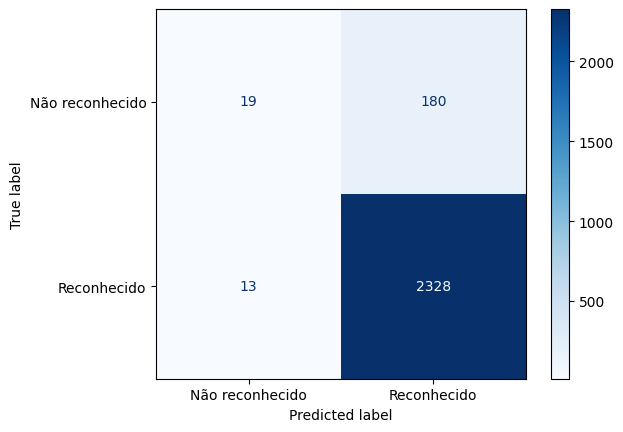

In [10]:
# Matriz de Confusão
ConfusionMatrixDisplay.from_estimator(best_rf_class_0_model, X_test_2018_2024_modelo1, y_test_2018_2024_modelo1, values_format='d', cmap='Blues', display_labels=['Não reconhecido', 'Reconhecido'])

## Balanceamento de Dados com SMOTE

In [11]:
# Divisão em Dados de Treino e Teste
X_smote = df_eventos_2018_2024_modelo1.drop('Status', axis=1)
y_smote = df_eventos_2018_2024_modelo1['Status']
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size = 0.2, random_state = 42, stratify = y_smote)

In [12]:
# Aplicar SMOTE apenas no conjunto de treino
smote = SMOTE(random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_smote, y_train_smote)

In [13]:
# Treinamento

# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes = {
    'rf_class_1__criterion': ['gini', 'entropy'],
    'rf_class_1__n_estimators': [150, 175, 200, 225, 250, 300],
    'rf_class_1__max_depth': [2, 4, 6, 8],
    'rf_class_1__min_samples_split': [2, 5, 10, 15, 100],
    'rf_class_1__min_samples_leaf': [1, 2, 5, 10],
    'rf_class_1__max_features': ['sqrt', 'log2', None]
}

# Criar pipeline com RobustScaler e RandomForestClassifier
pipeline_rf_class_1 = Pipeline([
    ('scaler', RobustScaler()),
    ('rf_class_1', RandomForestClassifier(random_state = 42))
])

# Realizar a busca bayesiana com validação cruzada
bayes_search_rf_class_1 = BayesSearchCV(
    pipeline_rf_class_1,
    search_spaces = param_grid_bayes,
    n_iter = 30,
    cv = 5,
    scoring = 'f1_weighted',
    n_jobs = 1,
    random_state = 42
)

# Ajustar a busca bayesiana ao conjunto de treino
bayes_search_rf_class_1.fit(X_train_smote, y_train_smote)

# Melhor modelo encontrado
best_rf_class_1_model = bayes_search_rf_class_1.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros: {bayes_search_rf_class_1.best_params_}")

# Fazer previsões com o conjunto de teste
y_pred_rf_class_1 = best_rf_class_1_model.predict(X_test_smote)

# Relatório de classificação
classification_report_rf_class_1 = metrics.classification_report(y_test_smote, y_pred_rf_class_1, digits=6, target_names=['Não reconhecido', 'Reconhecido'])
print('\n Classification report para Random Forest com SMOTE: \n')
print(classification_report_rf_class_1)

Melhores hiperparâmetros: OrderedDict([('rf_class_1__criterion', 'gini'), ('rf_class_1__max_depth', 8), ('rf_class_1__max_features', None), ('rf_class_1__min_samples_leaf', 1), ('rf_class_1__min_samples_split', 2), ('rf_class_1__n_estimators', 300)])

 Classification report para Random Forest com SMOTE: 

                 precision    recall  f1-score   support

Não reconhecido   0.394366  0.281407  0.328446       199
    Reconhecido   0.940367  0.963264  0.951678      2341

       accuracy                       0.909843      2540
      macro avg   0.667367  0.622335  0.640062      2540
   weighted avg   0.897590  0.909843  0.902850      2540



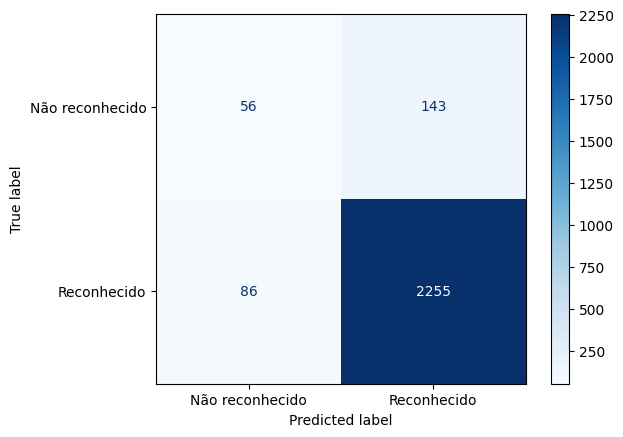

In [14]:
# Matriz de Confusão
ConfusionMatrixDisplay.from_estimator(best_rf_class_1_model, X_test_smote, y_test_smote, values_format='d', cmap='Blues', display_labels=['Não reconhecido', 'Reconhecido'])

## Avaliação das Variáveis de Importância
Avaliação das variáveis de importância de acordo com o modelo desbalanceado,  que apresentou o maior f1-score.

In [15]:
# Passo intermediário
X_train     = X_train_2018_2024_modelo1
y_train     = y_train_2018_2024_modelo1
X_test      = X_test_2018_2024_modelo1
y_test      = y_test_2018_2024_modelo1
model_type  = 'rf_class_0'
best_model  = best_rf_class_0_model

# Ajustar o melhor modelo encontrado (depois da busca bayesiana)
best_model.named_steps[model_type].fit(X_train, y_train)

# Obter a importância das features
importance_dict = {}
for feature, importance in zip(X_train.columns, best_model.named_steps[model_type].feature_importances_):
    importance_dict[feature] = importance
#importance_dict

# Transformar em DataFrame para organizar como tabela
importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Importance': list(importance_dict.values())
})

# Ordenar pela importância em ordem decrescente
importance_df = importance_df.sort_values(by='Importance', ascending=False)
estilo_tabelas(importance_df.head(10))

,Feature,Importance
0,DH_total_danos_humanos,0.268
3,PEPR_total_privado,0.107
59,QTDE_FAMILIAS_ATUALIZADAS,0.065
1,DM_total_danos_materiais,0.057
56,PDEFESGOTO,0.052
2,PEPL_total_publico,0.049
55,PDEFAGUA,0.047
54,DOMICILIO_AREARURAL,0.047
57,PDEFLIXO,0.044
58,PDEFSAN,0.036


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names


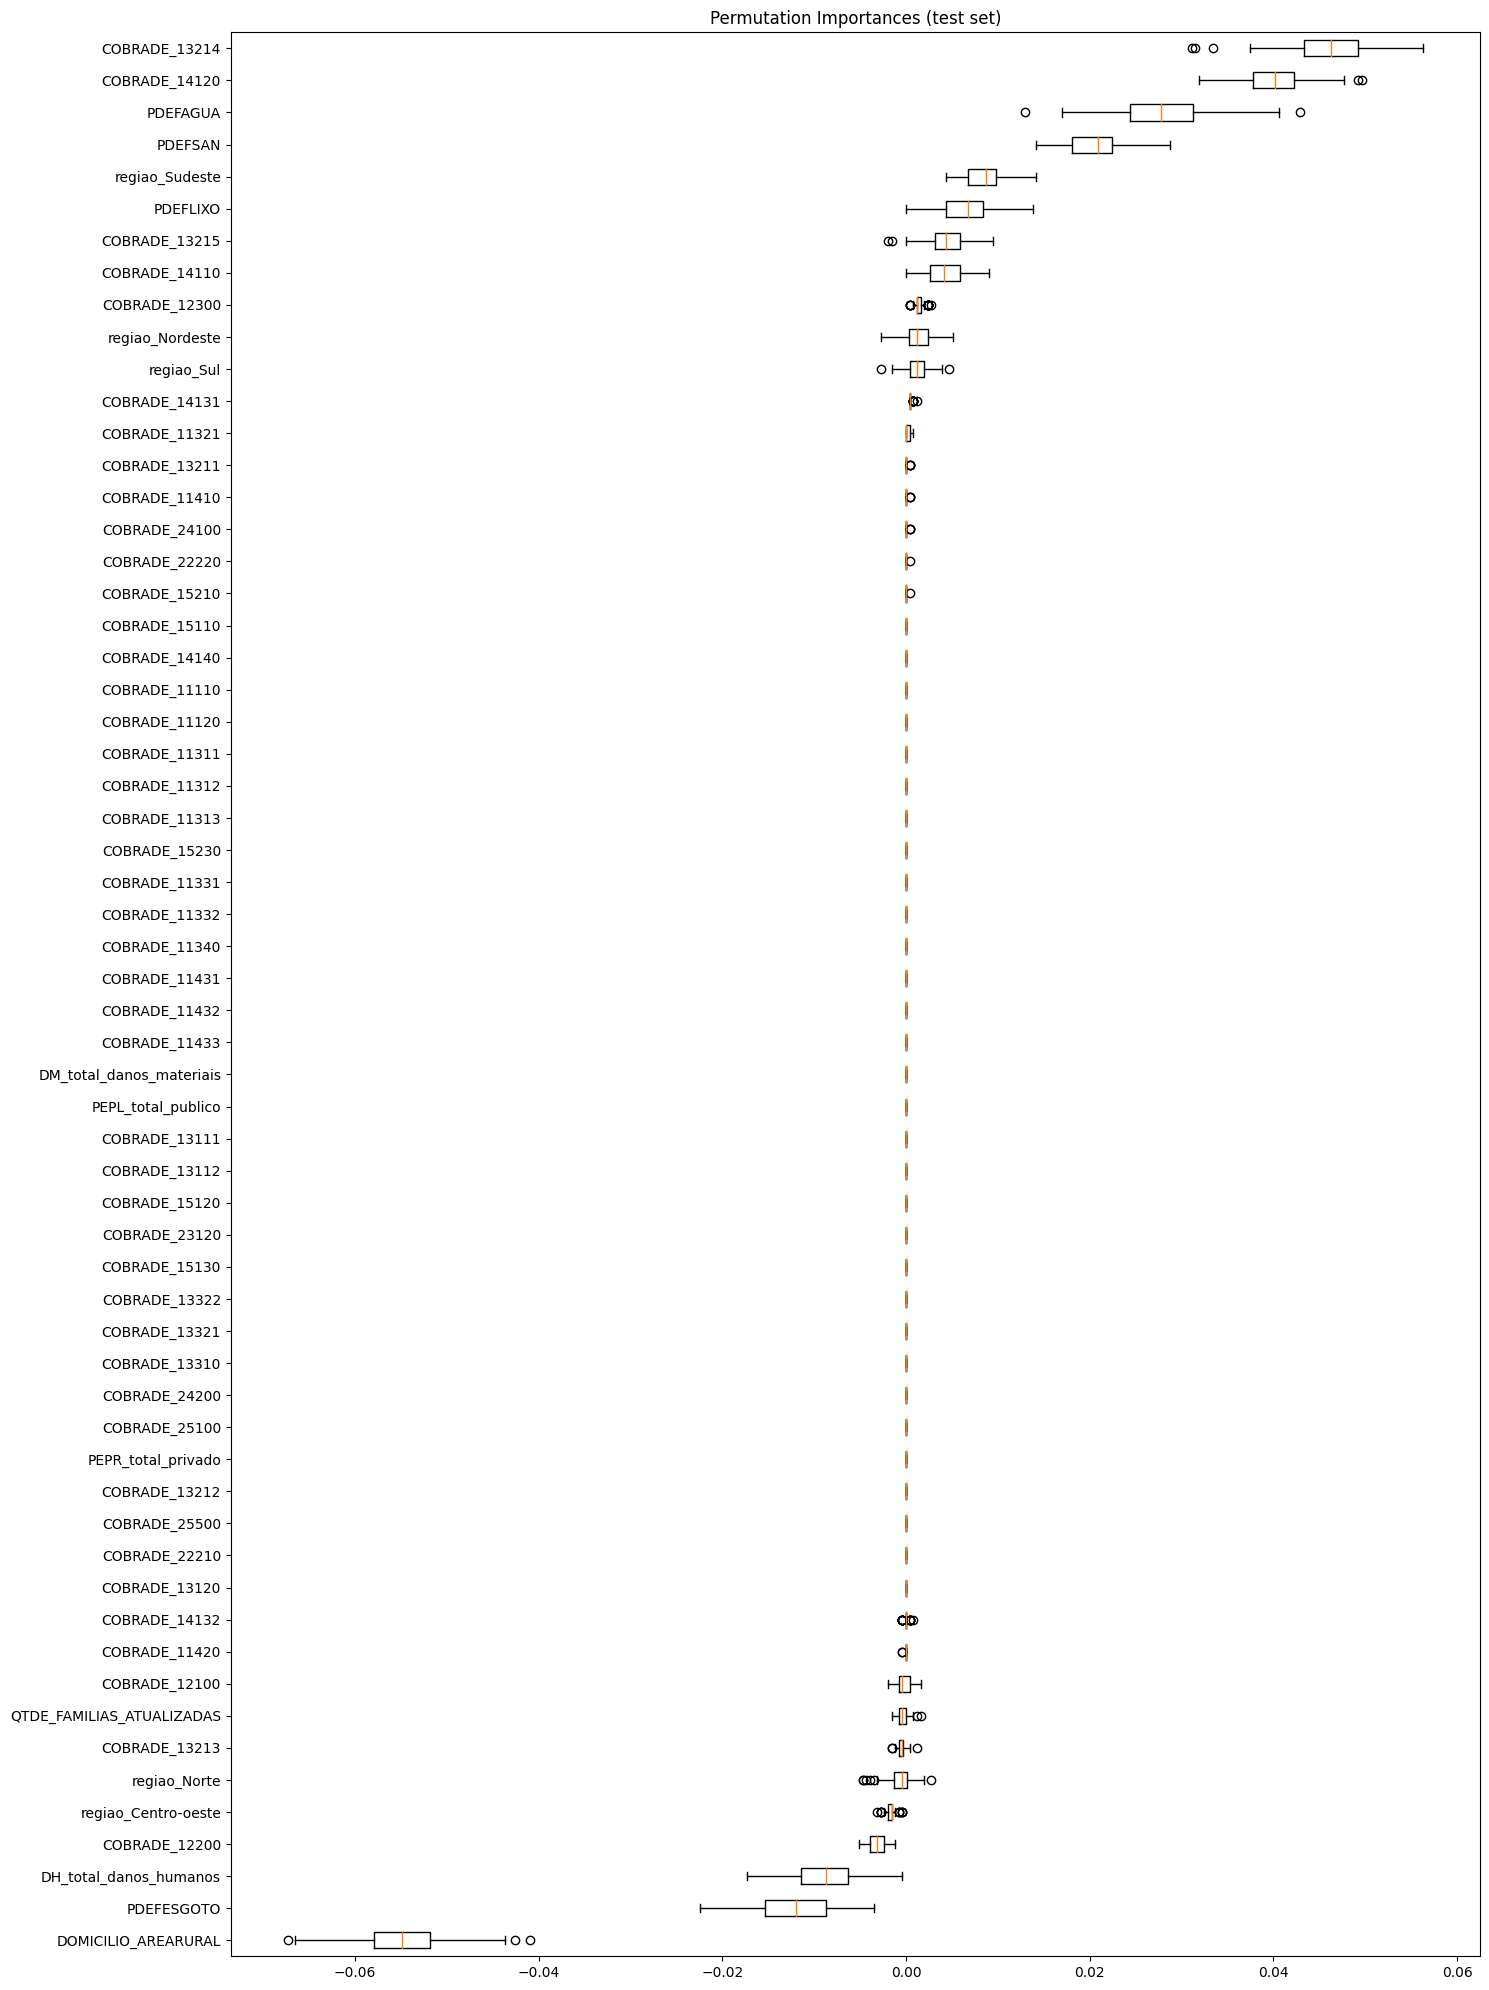

In [17]:
# Calcular os resultados (permutation_importance) da queda no desempenho do modelo ao embaralhar cada uma das variáveis.
result = permutation_importance(best_model, X_test, y_test, n_repeats = 100, random_state = 42, n_jobs = -1)

# Ordenar os resultados
sorted_idx = result.importances_mean.argsort()

# Gráfico boxplot pra mostrar a importância das variáveis
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels = X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.set_size_inches(15, 20)
fig.tight_layout()
plt.show()